# 1 - Loading required libraries

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression
import re
import gc
import os


# Filter_and_Grid_Search - internal library for variable selection and data preprocessing
#
import Filter_and_Grid_Search
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import two_forests, turn_variables_with_values

from Filter_and_Grid_Search import to_zip, br_correction, br_stat
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/'
PATH = 'D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/
D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/


In [5]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [6]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P']
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [7]:
COL_DEL

['UNNAMED: 0', 'PERIOD_7', 'LOSS_90P']

In [8]:
necessary_fields

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']

# 2 - Loading preprocessing data

In [41]:
PATH

'D:/Share/asmirnova5/Python-notebook/AF_ML_v2_2014/'

In [21]:
train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [22]:
y_train = train_for[target]
y_test = valid_for[target]
y_val = test_for[target]

train_for.drop('Unnamed: 0', axis=1, inplace=True)
valid_for.drop('Unnamed: 0', axis=1, inplace=True)
test_for.drop('Unnamed: 0', axis=1, inplace=True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [23]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

In [15]:
from keras.utils import np_utils

In [168]:
Y_test_2 = np_utils.to_categorical( y_test, 2)

In [169]:
#check correctness
X_1_2.shape,  X_2_2.shape, Y_test_2.shape

((1507599, 163), (185400, 163), (185400, 2))

# 3 - Loading tensorflow

In [11]:
from tensorflow.keras.layers import (
    Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [12]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [15]:
from keras.utils import np_utils
from tensorflow.keras.models import Model

In [17]:
import tensorflow as tf

In [18]:
print(tf.__version__)

2.3.0


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler


class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print('train_begin', '| time: ', tm)

    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print('epoch_end', '| time: ', tm)

        return


_time = E_time()

In [19]:
# DataGenerator is used to adjust the bad rate in each batch

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha=0.1, random_state=42,
                 shuffle=True, class_w=None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]

        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)

        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(
                self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        else:
            if data_tmp_b.shape[0] > 0:
                k = (self.alpha*self.batch_size /
                     data_tmp_b.shape[0] - 1)/(1-self.alpha)
                for i in range(0, int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(
                    self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))

            ix = np.random.RandomState(self.random_state).choice(
                data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)

            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        if self.num_classes > 1:
            y = np_utils.to_categorical(y, self.num_classes)

        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

# *

In [262]:
# Seed value
import tensorflow as tf
import numpy as np
import random
import os
seed_value = 29

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 4 - Spider - 6

In [267]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [51]:
def max_pool(min_pool, n_pool, padding_pool, str_pool, y):
    if y.shape[1] < (min_pool):

        return MaxPooling1D(pool_size=n_pool, padding=padding_pool, strides=1)(y)
    else:
        return MaxPooling1D(pool_size=n_pool, padding=padding_pool, strides=str_pool)(y)

In [318]:
def spider_model(l2_conv=None, reg=1E-5,
                 _bias=True,  n_features=163, n_pool=2, n_kernel=5, n_filters=5, n_strides=1,
                 classes=2, hidden=64, drop_out=0.25, drop_out_conv=0.001, drop_out_rate=4,
                 padding_pool='valid',
                 gl_pool_max=False):

    if reg == None:
        l2_batch_gamma = None
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta = l2(reg)

    x = Input(shape=(n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(x)

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut1_2 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(y)  # поправить
    shortcut1_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_2)
    shortcut1_4 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_3)
    shortcut1_5 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_4)

    # второй spider-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut2_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut2_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut2_2)
    shortcut2_4 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut2_3)

    y = Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий spider-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut3_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut3_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut3_2)

    y = Concatenate(axis=-1)([shortcut2_2, shortcut1_3, y])
    n = n+1
    # четвертый spider-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut4_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)

    y = Concatenate(axis=-1)([shortcut3_2, shortcut2_3, shortcut1_4, y])
    n = n+1
    y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
    print(n, drop_out_conv*(n**drop_out_rate))

    # пятый spider-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    y = Concatenate(
        axis=-1)([shortcut4_2, shortcut3_3, shortcut2_4, shortcut1_5, y])
    n = n+1
    y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
    print(n, drop_out_conv*(n**drop_out_rate))

    # шестой spider-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)

    else:
        z = GlobalAveragePooling1D()(y)

    z = Dense(hidden, activation='relu')(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu')(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    model_15 = Model(inputs=x, outputs=predictions)

    return model_15

In [233]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

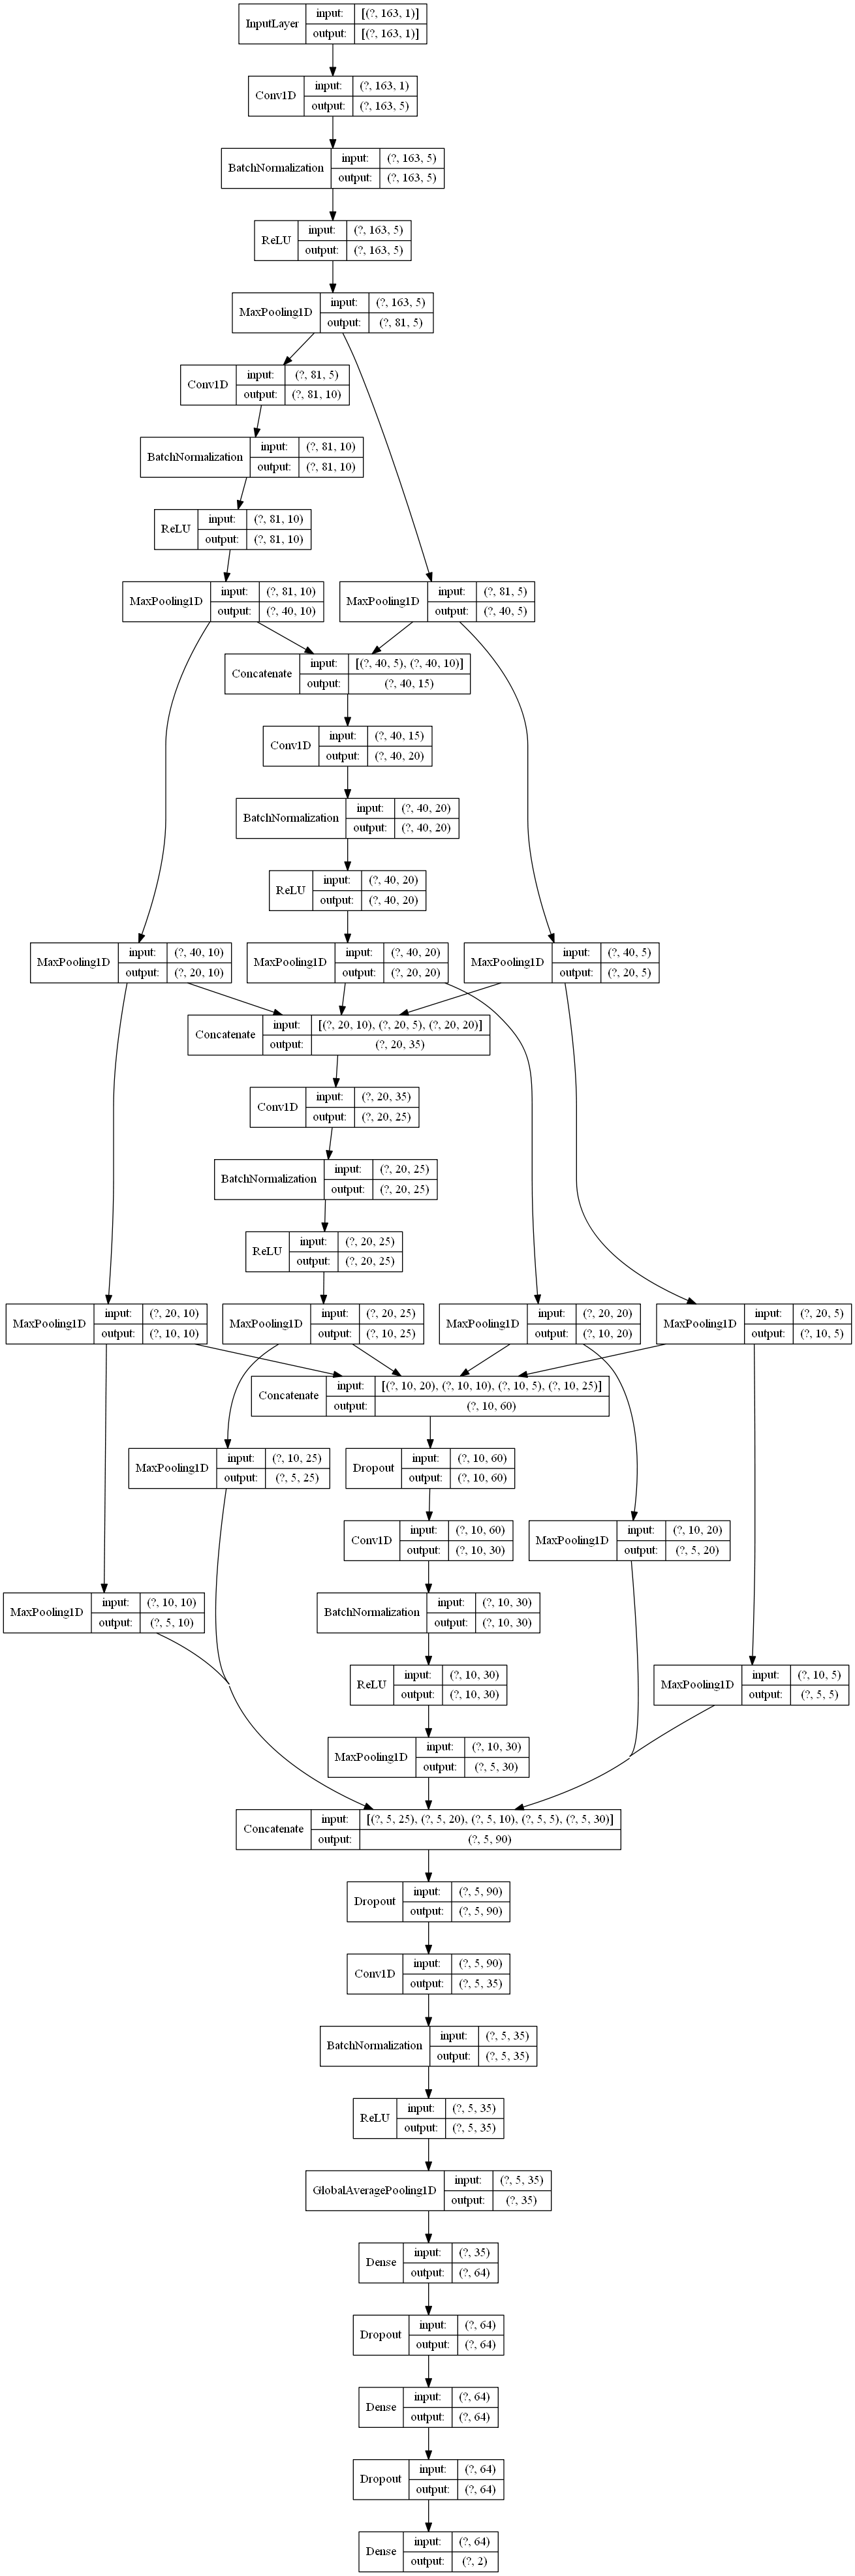

In [234]:
# Сomputational graph for Spider - 6
tf.keras.utils.plot_model(model_15, to_file='model.png',
                          show_shapes=True, show_layer_names=False, rankdir='TB')

In [242]:
training_generator = DataGenerator(
    train_for, x_col, y_col, batch_size=512, alpha=None, class_w=0.05)

In [256]:
initial_learning_rate = 0.005


def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 20.0

    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [337]:
# Grid Search
gl_p = [True, False]
l2_batch = [None, 1E-5, 1E-4]
n_ker = [3, 5, 7]
n_fil = [5, 10]
d_hidden = [30, 64, 100]
drop_out = [0.15, 0.25]
drop_out_conv = [0.001, 0.0015]

In [338]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden)

In [327]:
for p in param:
    print(str(p))

(True, None, 3, 5, 30)
(True, None, 3, 5, 64)
(True, None, 3, 5, 100)
(True, None, 3, 10, 30)
(True, None, 3, 10, 64)
(True, None, 3, 10, 100)
(True, None, 5, 5, 30)
(True, None, 5, 5, 64)
(True, None, 5, 5, 100)
(True, None, 5, 10, 30)
(True, None, 5, 10, 64)
(True, None, 5, 10, 100)
(True, None, 7, 5, 30)
(True, None, 7, 5, 64)
(True, None, 7, 5, 100)
(True, None, 7, 10, 30)
(True, None, 7, 10, 64)
(True, None, 7, 10, 100)
(True, 1e-05, 3, 5, 30)
(True, 1e-05, 3, 5, 64)
(True, 1e-05, 3, 5, 100)
(True, 1e-05, 3, 10, 30)
(True, 1e-05, 3, 10, 64)
(True, 1e-05, 3, 10, 100)
(True, 1e-05, 5, 5, 30)
(True, 1e-05, 5, 5, 64)
(True, 1e-05, 5, 5, 100)
(True, 1e-05, 5, 10, 30)
(True, 1e-05, 5, 10, 64)
(True, 1e-05, 5, 10, 100)
(True, 1e-05, 7, 5, 30)
(True, 1e-05, 7, 5, 64)
(True, 1e-05, 7, 5, 100)
(True, 1e-05, 7, 10, 30)
(True, 1e-05, 7, 10, 64)
(True, 1e-05, 7, 10, 100)
(True, 0.0001, 3, 5, 30)
(True, 0.0001, 3, 5, 64)
(True, 0.0001, 3, 5, 100)
(True, 0.0001, 3, 10, 30)
(True, 0.0001, 3, 10, 

In [338]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden)

In [ ]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0: 0.05, 1: 1}

result_all = pd.DataFrame()
result_all['name_model'] = None
result_all['params'] = None
result_all['val_GINI'] = None
result_all['val_APS'] = None
result_all['test_GINI'] = None
result_all['test_APS'] = None
j = 0

for p in param:

    model_grid = spider_model(gl_pool_max=p[0], reg=p[1],
                              n_kernel=p[2], n_filters=p[3], hidden=p[4])
    model_grid.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                       metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history_XX = model_grid.fit_generator(generator=training_generator,  # training_aug,
                                          validation_data=(X_2_2, Y_test_2),
                                          epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                          callbacks=[_time, EarlyStopping(monitor='val_loss', patience=20), LearningRateScheduler(lr_step_decay, verbose=1)])

    res_model_ = pd.DataFrame(
        history_XX.history, columns=history_XX.history.keys())
    name_m = 'model_spider6_grid' + \
        str(p[0]) + '_' + str(p[1]) + '_' + \
        str(p[2]) + '_' + str(p[3]) + '_' + str(p[4])
    model_grid.save(name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')

    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_test, predict_class_val[:, 1])
    GINI = 2*(metrics.roc_auc_score(y_test, predict_class_val[:, 1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_val, predict_class_test[:, 1])
    GINI_t = 2*(metrics.roc_auc_score(y_val, predict_class_test[:, 1])) - 1

    result_all.at[j, 'name_model'] = name_m
    result_all.at[j, 'params'] = str(p)
    result_all.at[j, 'val_GINI'] = GINI
    result_all.at[j, 'val_APS'] = APS
    result_all.at[j, 'test_GINI'] = GINI_t
    result_all.at[j, 'test_APS'] = APS_t
    j += 1
    print(name_m, 'test: ', GINI, APS, '| val: ', GINI_t, APS_t)

3 0.081
4 0.256
train_begin | time:  05.04.2021 09:40:02

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
epoch_end | time:  05.04.2021 09:48:02
2945/2945 - 477s - loss: 0.0103 - accuracy: 0.9671 - auc_11: 0.9923 - precision_11: 0.9671 - recall_11: 0.9671 - val_loss: 0.0460 - val_accuracy: 0.9914 - val_auc_11: 0.9989 - val_precision_11: 0.9914 - val_recall_11: 0.9914

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  05.04.2021 09:56:28
2945/2945 - 505s - loss: 0.0067 - accuracy: 0.9855 - auc_11: 0.9971 - precision_11: 0.9855 - recall_11: 0.9855 - val_loss: 0.1243 - val_accuracy: 0.9642 - val_auc_11: 0.9891 - val_precision_11: 0.9642 - val_recall_11: 0.9642

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  05.04.2021 10:04:48
2945/2945 - 501s - loss: 0.0062 - accuracy: 0.9869 - auc_11: 0.9976 - precision_11: 0.9869 - recall_11: 0.9869 - val_loss: 0.0307 - v


Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  05.04.2021 13:42:45
2945/2945 - 536s - loss: 0.0035 - accuracy: 0.9891 - auc_11: 0.9994 - precision_11: 0.9891 - recall_11: 0.9891 - val_loss: 0.0205 - val_accuracy: 0.9957 - val_auc_11: 0.9992 - val_precision_11: 0.9957 - val_recall_11: 0.9957

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 26/150
epoch_end | time:  05.04.2021 13:51:09
2945/2945 - 504s - loss: 0.0034 - accuracy: 0.9889 - auc_11: 0.9993 - precision_11: 0.9889 - recall_11: 0.9889 - val_loss: 0.0210 - val_accuracy: 0.9958 - val_auc_11: 0.9993 - val_precision_11: 0.9958 - val_recall_11: 0.9958

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 27/150
epoch_end | time:  05.04.2021 13:59:53
2945/2945 - 523s - loss: 0.0034 - accuracy: 0.9893 - auc_11: 0.9994 - precision_11: 0.9893 - recall_11: 0.9893 - val_loss: 0.0209 - val_accuracy: 0.9957 - val_auc_11: 0.9991 - val_prec


Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  05.04.2021 17:31:38
2945/2945 - 702s - loss: 0.0062 - accuracy: 0.9865 - auc_12: 0.9976 - precision_12: 0.9865 - recall_12: 0.9865 - val_loss: 0.0750 - val_accuracy: 0.9788 - val_auc_12: 0.9946 - val_precision_12: 0.9788 - val_recall_12: 0.9788

Epoch 00004: LearningRateScheduler reducing learning rate to 0.005.
Epoch 4/150
epoch_end | time:  05.04.2021 17:43:40
2945/2945 - 722s - loss: 0.0057 - accuracy: 0.9873 - auc_12: 0.9980 - precision_12: 0.9873 - recall_12: 0.9873 - val_loss: 0.0620 - val_accuracy: 0.9839 - val_auc_12: 0.9970 - val_precision_12: 0.9839 - val_recall_12: 0.9839

Epoch 00005: LearningRateScheduler reducing learning rate to 0.005.
Epoch 5/150
epoch_end | time:  05.04.2021 17:55:27
2945/2945 - 706s - loss: 0.0054 - accuracy: 0.9880 - auc_12: 0.9982 - precision_12: 0.9880 - recall_12: 0.9880 - val_loss: 0.0410 - val_accuracy: 0.9933 - val_auc_12: 0.9990 - val_precision_


Epoch 00027: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 27/150
epoch_end | time:  05.04.2021 21:45:25
2945/2945 - 583s - loss: 0.0034 - accuracy: 0.9893 - auc_12: 0.9993 - precision_12: 0.9893 - recall_12: 0.9893 - val_loss: 0.0214 - val_accuracy: 0.9956 - val_auc_12: 0.9994 - val_precision_12: 0.9956 - val_recall_12: 0.9956

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 28/150
epoch_end | time:  05.04.2021 21:55:16
2945/2945 - 591s - loss: 0.0034 - accuracy: 0.9894 - auc_12: 0.9994 - precision_12: 0.9894 - recall_12: 0.9894 - val_loss: 0.0245 - val_accuracy: 0.9937 - val_auc_12: 0.9994 - val_precision_12: 0.9937 - val_recall_12: 0.9937

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 29/150
epoch_end | time:  05.04.2021 22:05:13
2945/2945 - 597s - loss: 0.0033 - accuracy: 0.9891 - auc_12: 0.9994 - precision_12: 0.9891 - recall_12: 0.9891 - val_loss: 0.0220 - val_accuracy: 0.9949 - val_auc_12: 0.9994 - val_prec

epoch_end | time:  06.04.2021 01:07:14
2945/2945 - 505s - loss: 0.0043 - accuracy: 0.9882 - auc_13: 0.9988 - precision_13: 0.9882 - recall_13: 0.9882 - val_loss: 0.0215 - val_accuracy: 0.9950 - val_auc_13: 0.9993 - val_precision_13: 0.9950 - val_recall_13: 0.9950

Epoch 00020: LearningRateScheduler reducing learning rate to 0.005.
Epoch 20/150
epoch_end | time:  06.04.2021 01:15:34
2945/2945 - 499s - loss: 0.0043 - accuracy: 0.9887 - auc_13: 0.9989 - precision_13: 0.9887 - recall_13: 0.9887 - val_loss: 0.0313 - val_accuracy: 0.9940 - val_auc_13: 0.9991 - val_precision_13: 0.9940 - val_recall_13: 0.9940

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 21/150
epoch_end | time:  06.04.2021 01:23:59
2945/2945 - 505s - loss: 0.0039 - accuracy: 0.9891 - auc_13: 0.9992 - precision_13: 0.9891 - recall_13: 0.9891 - val_loss: 0.0227 - val_accuracy: 0.9958 - val_auc_13: 0.9994 - val_precision_13: 0.9958 - val_recall_13: 0.9958

Epoch 00022: LearningRateScheduler reducin


Epoch 00043: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 43/150
epoch_end | time:  06.04.2021 04:28:28
2945/2945 - 506s - loss: 0.0032 - accuracy: 0.9892 - auc_13: 0.9994 - precision_13: 0.9892 - recall_13: 0.9892 - val_loss: 0.0193 - val_accuracy: 0.9959 - val_auc_13: 0.9993 - val_precision_13: 0.9959 - val_recall_13: 0.9959

Epoch 00044: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 44/150
epoch_end | time:  06.04.2021 04:36:49
2945/2945 - 501s - loss: 0.0032 - accuracy: 0.9892 - auc_13: 0.9994 - precision_13: 0.9892 - recall_13: 0.9892 - val_loss: 0.0201 - val_accuracy: 0.9957 - val_auc_13: 0.9993 - val_precision_13: 0.9957 - val_recall_13: 0.9957

Epoch 00045: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 45/150
epoch_end | time:  06.04.2021 04:45:11
2945/2945 - 502s - loss: 0.0032 - accuracy: 0.9891 - auc_13: 0.9994 - precision_13: 0.9891 - recall_13: 0.9891 - val_loss: 0.0206 - val_acc


Epoch 00012: LearningRateScheduler reducing learning rate to 0.005.
Epoch 12/150
epoch_end | time:  06.04.2021 09:06:32
2945/2945 - 920s - loss: 0.0039 - accuracy: 0.9893 - auc_14: 0.9991 - precision_14: 0.9893 - recall_14: 0.9893 - val_loss: 0.0326 - val_accuracy: 0.9933 - val_auc_14: 0.9994 - val_precision_14: 0.9933 - val_recall_14: 0.9933

Epoch 00013: LearningRateScheduler reducing learning rate to 0.005.
Epoch 13/150
epoch_end | time:  06.04.2021 09:21:58
2945/2945 - 925s - loss: 0.0037 - accuracy: 0.9890 - auc_14: 0.9991 - precision_14: 0.9890 - recall_14: 0.9890 - val_loss: 0.0208 - val_accuracy: 0.9953 - val_auc_14: 0.9993 - val_precision_14: 0.9953 - val_recall_14: 0.9953

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
Epoch 14/150
epoch_end | time:  06.04.2021 09:37:22
2945/2945 - 924s - loss: 0.0037 - accuracy: 0.9890 - auc_14: 0.9991 - precision_14: 0.9890 - recall_14: 0.9890 - val_loss: 0.0245 - val_accuracy: 0.9931 - val_auc_14: 0.9993 - val_precisi

model_spider6_gridTrue_None_3_10_30 test:  0.8592148107198936 0.06510761647503284 | val:  0.8695659213719673 0.06124626084944128
3 0.081
4 0.256
train_begin | time:  06.04.2021 15:38:20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
epoch_end | time:  06.04.2021 15:54:04
2945/2945 - 941s - loss: 0.0090 - accuracy: 0.9735 - auc_15: 0.9943 - precision_15: 0.9735 - recall_15: 0.9735 - val_loss: 0.0844 - val_accuracy: 0.9804 - val_auc_15: 0.9936 - val_precision_15: 0.9804 - val_recall_15: 0.9804

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  06.04.2021 16:10:33
2945/2945 - 989s - loss: 0.0059 - accuracy: 0.9879 - auc_15: 0.9977 - precision_15: 0.9879 - recall_15: 0.9879 - val_loss: 0.0245 - val_accuracy: 0.9957 - val_auc_15: 0.9994 - val_precision_15: 0.9957 - val_recall_15: 0.9957

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  06.04.2021 16:29:41
2945

epoch_end | time:  06.04.2021 22:59:24
2945/2945 - 1004s - loss: 0.0022 - accuracy: 0.9904 - auc_15: 0.9996 - precision_15: 0.9904 - recall_15: 0.9904 - val_loss: 0.0247 - val_accuracy: 0.9952 - val_auc_15: 0.9989 - val_precision_15: 0.9952 - val_recall_15: 0.9952

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  06.04.2021 23:16:08
2945/2945 - 1003s - loss: 0.0022 - accuracy: 0.9904 - auc_15: 0.9996 - precision_15: 0.9904 - recall_15: 0.9904 - val_loss: 0.0268 - val_accuracy: 0.9945 - val_auc_15: 0.9989 - val_precision_15: 0.9945 - val_recall_15: 0.9945

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 26/150
epoch_end | time:  06.04.2021 23:33:31
2945/2945 - 1043s - loss: 0.0021 - accuracy: 0.9904 - auc_15: 0.9996 - precision_15: 0.9904 - recall_15: 0.9904 - val_loss: 0.0250 - val_accuracy: 0.9957 - val_auc_15: 0.9988 - val_precision_15: 0.9957 - val_recall_15: 0.9957

Epoch 00027: LearningRateScheduler red


Epoch 00008: LearningRateScheduler reducing learning rate to 0.005.
Epoch 8/150
epoch_end | time:  07.04.2021 05:43:37
2945/2945 - 992s - loss: 0.0041 - accuracy: 0.9893 - auc_16: 0.9989 - precision_16: 0.9893 - recall_16: 0.9893 - val_loss: 0.0305 - val_accuracy: 0.9932 - val_auc_16: 0.9995 - val_precision_16: 0.9932 - val_recall_16: 0.9932

Epoch 00009: LearningRateScheduler reducing learning rate to 0.005.
Epoch 9/150
epoch_end | time:  07.04.2021 06:00:16
2945/2945 - 998s - loss: 0.0039 - accuracy: 0.9896 - auc_16: 0.9990 - precision_16: 0.9896 - recall_16: 0.9896 - val_loss: 0.0191 - val_accuracy: 0.9964 - val_auc_16: 0.9992 - val_precision_16: 0.9964 - val_recall_16: 0.9964

Epoch 00010: LearningRateScheduler reducing learning rate to 0.005.
Epoch 10/150
epoch_end | time:  07.04.2021 06:16:53
2945/2945 - 997s - loss: 0.0039 - accuracy: 0.9895 - auc_16: 0.9990 - precision_16: 0.9895 - recall_16: 0.9895 - val_loss: 0.0240 - val_accuracy: 0.9955 - val_auc_16: 0.9993 - val_precision

epoch_end | time:  07.04.2021 12:11:24
2945/2945 - 1088s - loss: 0.0061 - accuracy: 0.9872 - auc_17: 0.9976 - precision_17: 0.9872 - recall_17: 0.9872 - val_loss: 0.1011 - val_accuracy: 0.9698 - val_auc_17: 0.9928 - val_precision_17: 0.9698 - val_recall_17: 0.9698

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  07.04.2021 12:30:41
2945/2945 - 1156s - loss: 0.0056 - accuracy: 0.9879 - auc_17: 0.9980 - precision_17: 0.9879 - recall_17: 0.9879 - val_loss: 0.0830 - val_accuracy: 0.9785 - val_auc_17: 0.9947 - val_precision_17: 0.9785 - val_recall_17: 0.9785

Epoch 00004: LearningRateScheduler reducing learning rate to 0.005.
Epoch 4/150
epoch_end | time:  07.04.2021 12:48:55
2945/2945 - 1094s - loss: 0.0052 - accuracy: 0.9885 - auc_17: 0.9983 - precision_17: 0.9885 - recall_17: 0.9885 - val_loss: 0.0566 - val_accuracy: 0.9832 - val_auc_17: 0.9978 - val_precision_17: 0.9832 - val_recall_17: 0.9832

Epoch 00005: LearningRateScheduler reducin


Epoch 00026: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 26/150
epoch_end | time:  07.04.2021 19:00:56
2945/2945 - 1236s - loss: 0.0027 - accuracy: 0.9890 - auc_17: 0.9995 - precision_17: 0.9890 - recall_17: 0.9890 - val_loss: 0.0228 - val_accuracy: 0.9942 - val_auc_17: 0.9990 - val_precision_17: 0.9942 - val_recall_17: 0.9942
model_spider6_gridTrue_None_5_5_30 test:  0.8663585836190522 0.0794747635981735 | val:  0.8477460223896327 0.0660615370904464
3 0.081
4 0.256
train_begin | time:  07.04.2021 19:03:10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
epoch_end | time:  07.04.2021 19:22:17
2945/2945 - 1144s - loss: 0.0091 - accuracy: 0.9719 - auc_18: 0.9939 - precision_18: 0.9719 - recall_18: 0.9719 - val_loss: 0.5057 - val_accuracy: 0.8805 - val_auc_18: 0.9066 - val_precision_18: 0.8805 - val_recall_18: 0.8805

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  07.04.2021 19:41:20
294

epoch_end | time:  08.04.2021 00:23:59
2945/2945 - 715s - loss: 0.0028 - accuracy: 0.9895 - auc_18: 0.9995 - precision_18: 0.9895 - recall_18: 0.9895 - val_loss: 0.0210 - val_accuracy: 0.9949 - val_auc_18: 0.9991 - val_precision_18: 0.9949 - val_recall_18: 0.9949

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 24/150
epoch_end | time:  08.04.2021 00:35:58
2945/2945 - 718s - loss: 0.0028 - accuracy: 0.9893 - auc_18: 0.9995 - precision_18: 0.9893 - recall_18: 0.9893 - val_loss: 0.0206 - val_accuracy: 0.9960 - val_auc_18: 0.9989 - val_precision_18: 0.9960 - val_recall_18: 0.9960

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  08.04.2021 00:47:56
2945/2945 - 718s - loss: 0.0027 - accuracy: 0.9898 - auc_18: 0.9995 - precision_18: 0.9898 - recall_18: 0.9898 - val_loss: 0.0222 - val_accuracy: 0.9947 - val_auc_18: 0.9991 - val_precision_18: 0.9947 - val_recall_18: 0.9947

Epoch 00026: LearningRateScheduler reduci


Epoch 00013: LearningRateScheduler reducing learning rate to 0.005.
Epoch 13/150
epoch_end | time:  08.04.2021 05:07:07
2945/2945 - 701s - loss: 0.0040 - accuracy: 0.9889 - auc_19: 0.9990 - precision_19: 0.9889 - recall_19: 0.9889 - val_loss: 0.0945 - val_accuracy: 0.9747 - val_auc_19: 0.9925 - val_precision_19: 0.9747 - val_recall_19: 0.9747

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
Epoch 14/150
epoch_end | time:  08.04.2021 05:18:44
2945/2945 - 697s - loss: 0.0040 - accuracy: 0.9891 - auc_19: 0.9990 - precision_19: 0.9891 - recall_19: 0.9891 - val_loss: 0.0283 - val_accuracy: 0.9949 - val_auc_19: 0.9994 - val_precision_19: 0.9949 - val_recall_19: 0.9949

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
Epoch 15/150
epoch_end | time:  08.04.2021 05:30:24
2945/2945 - 700s - loss: 0.0040 - accuracy: 0.9890 - auc_19: 0.9990 - precision_19: 0.9890 - recall_19: 0.9890 - val_loss: 0.0207 - val_accuracy: 0.9949 - val_auc_19: 0.9993 - val_precisi

epoch_end | time:  08.04.2021 09:43:20
2945/2945 - 1127s - loss: 0.0088 - accuracy: 0.9734 - auc_20: 0.9945 - precision_20: 0.9734 - recall_20: 0.9734 - val_loss: 0.0611 - val_accuracy: 0.9860 - val_auc_20: 0.9980 - val_precision_20: 0.9860 - val_recall_20: 0.9860

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  08.04.2021 10:01:32
2945/2945 - 1092s - loss: 0.0056 - accuracy: 0.9878 - auc_20: 0.9980 - precision_20: 0.9878 - recall_20: 0.9878 - val_loss: 0.0333 - val_accuracy: 0.9926 - val_auc_20: 0.9989 - val_precision_20: 0.9926 - val_recall_20: 0.9926

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  08.04.2021 10:19:02
2945/2945 - 1050s - loss: 0.0050 - accuracy: 0.9887 - auc_20: 0.9984 - precision_20: 0.9887 - recall_20: 0.9887 - val_loss: 0.0270 - val_accuracy: 0.9943 - val_auc_20: 0.9994 - val_precision_20: 0.9943 - val_recall_20: 0.9943

Epoch 00004: LearningRateScheduler reducin


Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  08.04.2021 17:02:02
2945/2945 - 1090s - loss: 0.0016 - accuracy: 0.9920 - auc_20: 0.9997 - precision_20: 0.9920 - recall_20: 0.9920 - val_loss: 0.0311 - val_accuracy: 0.9945 - val_auc_20: 0.9985 - val_precision_20: 0.9945 - val_recall_20: 0.9945

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 26/150
epoch_end | time:  08.04.2021 17:20:08
2945/2945 - 1085s - loss: 0.0015 - accuracy: 0.9918 - auc_20: 0.9997 - precision_20: 0.9918 - recall_20: 0.9918 - val_loss: 0.0350 - val_accuracy: 0.9941 - val_auc_20: 0.9984 - val_precision_20: 0.9941 - val_recall_20: 0.9941

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 27/150
epoch_end | time:  08.04.2021 17:38:45
2945/2945 - 1117s - loss: 0.0015 - accuracy: 0.9919 - auc_20: 0.9998 - precision_20: 0.9919 - recall_20: 0.9919 - val_loss: 0.0311 - val_accuracy: 0.9947 - val_auc_20: 0.9985 - val_p

epoch_end | time:  09.04.2021 01:43:27
2945/2945 - 1327s - loss: 0.0021 - accuracy: 0.9911 - auc_21: 0.9996 - precision_21: 0.9911 - recall_21: 0.9911 - val_loss: 0.0269 - val_accuracy: 0.9952 - val_auc_21: 0.9987 - val_precision_21: 0.9952 - val_recall_21: 0.9952

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 22/150
epoch_end | time:  09.04.2021 02:05:36
2945/2945 - 1328s - loss: 0.0018 - accuracy: 0.9917 - auc_21: 0.9997 - precision_21: 0.9917 - recall_21: 0.9917 - val_loss: 0.0307 - val_accuracy: 0.9947 - val_auc_21: 0.9986 - val_precision_21: 0.9947 - val_recall_21: 0.9947

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 23/150
epoch_end | time:  09.04.2021 02:27:41
2945/2945 - 1325s - loss: 0.0016 - accuracy: 0.9919 - auc_21: 0.9997 - precision_21: 0.9919 - recall_21: 0.9919 - val_loss: 0.0299 - val_accuracy: 0.9951 - val_auc_21: 0.9985 - val_precision_21: 0.9951 - val_recall_21: 0.9951

Epoch 00024: LearningRateScheduler red


Epoch 00019: LearningRateScheduler reducing learning rate to 0.005.
Epoch 19/150
epoch_end | time:  09.04.2021 10:24:32
2945/2945 - 1372s - loss: 0.0028 - accuracy: 0.9904 - auc_22: 0.9993 - precision_22: 0.9904 - recall_22: 0.9904 - val_loss: 0.0400 - val_accuracy: 0.9953 - val_auc_22: 0.9987 - val_precision_22: 0.9953 - val_recall_22: 0.9953

Epoch 00020: LearningRateScheduler reducing learning rate to 0.005.
Epoch 20/150
epoch_end | time:  09.04.2021 10:48:09
2945/2945 - 1416s - loss: 0.0025 - accuracy: 0.9907 - auc_22: 0.9994 - precision_22: 0.9907 - recall_22: 0.9907 - val_loss: 0.0306 - val_accuracy: 0.9941 - val_auc_22: 0.9990 - val_precision_22: 0.9941 - val_recall_22: 0.9941

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 21/150
epoch_end | time:  09.04.2021 11:13:47
2945/2945 - 1537s - loss: 0.0019 - accuracy: 0.9923 - auc_22: 0.9996 - precision_22: 0.9923 - recall_22: 0.9923 - val_loss: 0.0346 - val_accuracy: 0.9953 - val_auc_22: 0.9986 - val_pre

epoch_end | time:  09.04.2021 17:37:09
2945/2945 - 786s - loss: 0.0036 - accuracy: 0.9889 - auc_23: 0.9991 - precision_23: 0.9889 - recall_23: 0.9889 - val_loss: 0.0206 - val_accuracy: 0.9961 - val_auc_23: 0.9992 - val_precision_23: 0.9961 - val_recall_23: 0.9961

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
Epoch 16/150
epoch_end | time:  09.04.2021 17:50:06
2945/2945 - 776s - loss: 0.0035 - accuracy: 0.9896 - auc_23: 0.9992 - precision_23: 0.9896 - recall_23: 0.9896 - val_loss: 0.0205 - val_accuracy: 0.9951 - val_auc_23: 0.9991 - val_precision_23: 0.9951 - val_recall_23: 0.9951

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
Epoch 17/150
epoch_end | time:  09.04.2021 18:04:56
2945/2945 - 889s - loss: 0.0035 - accuracy: 0.9892 - auc_23: 0.9992 - precision_23: 0.9892 - recall_23: 0.9892 - val_loss: 0.0332 - val_accuracy: 0.9923 - val_auc_23: 0.9989 - val_precision_23: 0.9923 - val_recall_23: 0.9923

Epoch 00018: LearningRateScheduler reducing


Epoch 00006: LearningRateScheduler reducing learning rate to 0.005.
Epoch 6/150
epoch_end | time:  09.04.2021 22:51:54
2945/2945 - 764s - loss: 0.0044 - accuracy: 0.9888 - auc_24: 0.9989 - precision_24: 0.9888 - recall_24: 0.9888 - val_loss: 0.0669 - val_accuracy: 0.9808 - val_auc_24: 0.9960 - val_precision_24: 0.9808 - val_recall_24: 0.9808

Epoch 00007: LearningRateScheduler reducing learning rate to 0.005.
Epoch 7/150
epoch_end | time:  09.04.2021 23:04:36
2945/2945 - 762s - loss: 0.0043 - accuracy: 0.9891 - auc_24: 0.9989 - precision_24: 0.9891 - recall_24: 0.9891 - val_loss: 0.0461 - val_accuracy: 0.9922 - val_auc_24: 0.9992 - val_precision_24: 0.9922 - val_recall_24: 0.9922

Epoch 00008: LearningRateScheduler reducing learning rate to 0.005.
Epoch 8/150
epoch_end | time:  09.04.2021 23:17:14
2945/2945 - 758s - loss: 0.0041 - accuracy: 0.9892 - auc_24: 0.9990 - precision_24: 0.9892 - recall_24: 0.9892 - val_loss: 0.0275 - val_accuracy: 0.9923 - val_auc_24: 0.9991 - val_precision_


Epoch 00030: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 30/150
epoch_end | time:  10.04.2021 03:58:26
2945/2945 - 765s - loss: 0.0020 - accuracy: 0.9901 - auc_24: 0.9997 - precision_24: 0.9901 - recall_24: 0.9901 - val_loss: 0.0242 - val_accuracy: 0.9946 - val_auc_24: 0.9986 - val_precision_24: 0.9946 - val_recall_24: 0.9946

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 31/150
epoch_end | time:  10.04.2021 04:11:17
2945/2945 - 771s - loss: 0.0020 - accuracy: 0.9902 - auc_24: 0.9997 - precision_24: 0.9902 - recall_24: 0.9902 - val_loss: 0.0244 - val_accuracy: 0.9945 - val_auc_24: 0.9986 - val_precision_24: 0.9945 - val_recall_24: 0.9945

Epoch 00032: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 32/150
epoch_end | time:  10.04.2021 04:24:08
2945/2945 - 770s - loss: 0.0020 - accuracy: 0.9905 - auc_24: 0.9997 - precision_24: 0.9905 - recall_24: 0.9905 - val_loss: 0.0247 - val_accuracy: 0.9946 - val_auc_24: 0.9985 - val_prec

epoch_end | time:  10.04.2021 08:47:49
2945/2945 - 769s - loss: 0.0035 - accuracy: 0.9893 - auc_25: 0.9991 - precision_25: 0.9893 - recall_25: 0.9893 - val_loss: 0.0225 - val_accuracy: 0.9958 - val_auc_25: 0.9994 - val_precision_25: 0.9958 - val_recall_25: 0.9958

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
Epoch 16/150
epoch_end | time:  10.04.2021 09:02:21
2945/2945 - 871s - loss: 0.0034 - accuracy: 0.9897 - auc_25: 0.9992 - precision_25: 0.9897 - recall_25: 0.9897 - val_loss: 0.0297 - val_accuracy: 0.9921 - val_auc_25: 0.9988 - val_precision_25: 0.9921 - val_recall_25: 0.9921

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
Epoch 17/150
epoch_end | time:  10.04.2021 09:18:14
2945/2945 - 952s - loss: 0.0033 - accuracy: 0.9896 - auc_25: 0.9992 - precision_25: 0.9896 - recall_25: 0.9896 - val_loss: 0.0456 - val_accuracy: 0.9890 - val_auc_25: 0.9982 - val_precision_25: 0.9890 - val_recall_25: 0.9890

Epoch 00018: LearningRateScheduler reducing


Epoch 00006: LearningRateScheduler reducing learning rate to 0.005.
Epoch 6/150
epoch_end | time:  10.04.2021 15:23:43
2945/2945 - 1256s - loss: 0.0039 - accuracy: 0.9888 - auc_26: 0.9990 - precision_26: 0.9888 - recall_26: 0.9888 - val_loss: 0.0268 - val_accuracy: 0.9921 - val_auc_26: 0.9992 - val_precision_26: 0.9921 - val_recall_26: 0.9921

Epoch 00007: LearningRateScheduler reducing learning rate to 0.005.
Epoch 7/150
epoch_end | time:  10.04.2021 15:44:38
2945/2945 - 1255s - loss: 0.0037 - accuracy: 0.9893 - auc_26: 0.9991 - precision_26: 0.9893 - recall_26: 0.9893 - val_loss: 0.0374 - val_accuracy: 0.9921 - val_auc_26: 0.9991 - val_precision_26: 0.9921 - val_recall_26: 0.9921

Epoch 00008: LearningRateScheduler reducing learning rate to 0.005.
Epoch 8/150
epoch_end | time:  10.04.2021 16:05:36
2945/2945 - 1257s - loss: 0.0035 - accuracy: 0.9889 - auc_26: 0.9992 - precision_26: 0.9889 - recall_26: 0.9889 - val_loss: 0.0229 - val_accuracy: 0.9944 - val_auc_26: 0.9991 - val_precisi

epoch_end | time:  10.04.2021 23:26:59
2945/2945 - 1235s - loss: 0.0084 - accuracy: 0.9739 - auc_27: 0.9951 - precision_27: 0.9739 - recall_27: 0.9739 - val_loss: 0.0363 - val_accuracy: 0.9934 - val_auc_27: 0.9994 - val_precision_27: 0.9934 - val_recall_27: 0.9934

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  10.04.2021 23:47:31
2945/2945 - 1231s - loss: 0.0053 - accuracy: 0.9887 - auc_27: 0.9984 - precision_27: 0.9887 - recall_27: 0.9887 - val_loss: 0.0388 - val_accuracy: 0.9912 - val_auc_27: 0.9993 - val_precision_27: 0.9912 - val_recall_27: 0.9912

Epoch 00003: LearningRateScheduler reducing learning rate to 0.005.
Epoch 3/150
epoch_end | time:  11.04.2021 00:08:13
2945/2945 - 1242s - loss: 0.0047 - accuracy: 0.9889 - auc_27: 0.9987 - precision_27: 0.9889 - recall_27: 0.9889 - val_loss: 0.0293 - val_accuracy: 0.9957 - val_auc_27: 0.9996 - val_precision_27: 0.9957 - val_recall_27: 0.9957

Epoch 00004: LearningRateScheduler reducin


Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  11.04.2021 07:43:58
2945/2945 - 1238s - loss: 0.0010 - accuracy: 0.9945 - auc_27: 0.9998 - precision_27: 0.9945 - recall_27: 0.9945 - val_loss: 0.0468 - val_accuracy: 0.9955 - val_auc_27: 0.9981 - val_precision_27: 0.9955 - val_recall_27: 0.9955
model_spider6_gridTrue_None_7_10_64 test:  0.8315495245208451 0.06697573492729197 | val:  0.8514501114696071 0.07350068694529677
3 0.081
4 0.256
train_begin | time:  11.04.2021 07:45:35

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
epoch_end | time:  11.04.2021 08:08:33
2945/2945 - 1373s - loss: 0.0082 - accuracy: 0.9752 - auc_28: 0.9953 - precision_28: 0.9752 - recall_28: 0.9752 - val_loss: 0.0262 - val_accuracy: 0.9947 - val_auc_28: 0.9995 - val_precision_28: 0.9947 - val_recall_28: 0.9947

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005.
Epoch 2/150
epoch_end | time:  11.04.2021 08:31:11


epoch_end | time:  11.04.2021 16:25:41
2945/2945 - 1371s - loss: 0.0011 - accuracy: 0.9942 - auc_28: 0.9998 - precision_28: 0.9942 - recall_28: 0.9942 - val_loss: 0.0549 - val_accuracy: 0.9960 - val_auc_28: 0.9977 - val_precision_28: 0.9960 - val_recall_28: 0.9960

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 24/150
epoch_end | time:  11.04.2021 16:48:26
2945/2945 - 1365s - loss: 0.0011 - accuracy: 0.9944 - auc_28: 0.9998 - precision_28: 0.9944 - recall_28: 0.9944 - val_loss: 0.0497 - val_accuracy: 0.9952 - val_auc_28: 0.9981 - val_precision_28: 0.9952 - val_recall_28: 0.9952

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 25/150
epoch_end | time:  11.04.2021 17:11:03
2945/2945 - 1356s - loss: 9.8364e-04 - accuracy: 0.9946 - auc_28: 0.9998 - precision_28: 0.9946 - recall_28: 0.9946 - val_loss: 0.0614 - val_accuracy: 0.9954 - val_auc_28: 0.9978 - val_precision_28: 0.9954 - val_recall_28: 0.9954
model_spider6_gridTrue_None_7_10_10


Epoch 00022: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 22/150
epoch_end | time:  11.04.2021 20:38:02
2945/2945 - 549s - loss: 0.0042 - accuracy: 0.9886 - auc_29: 0.9993 - precision_29: 0.9886 - recall_29: 0.9886 - val_loss: 0.0268 - val_accuracy: 0.9913 - val_auc_29: 0.9994 - val_precision_29: 0.9913 - val_recall_29: 0.9913

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 23/150
epoch_end | time:  11.04.2021 20:47:18
2945/2945 - 556s - loss: 0.0041 - accuracy: 0.9879 - auc_29: 0.9992 - precision_29: 0.9879 - recall_29: 0.9879 - val_loss: 0.0292 - val_accuracy: 0.9925 - val_auc_29: 0.9994 - val_precision_29: 0.9925 - val_recall_29: 0.9925

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 24/150
epoch_end | time:  11.04.2021 20:56:35
2945/2945 - 556s - loss: 0.0041 - accuracy: 0.9881 - auc_29: 0.9993 - precision_29: 0.9881 - recall_29: 0.9881 - val_loss: 0.0269 - val_accuracy: 0.9928 - val_auc_29: 0.9994 - val_prec

epoch_end | time:  12.04.2021 00:07:29
2945/2945 - 521s - loss: 0.0056 - accuracy: 0.9877 - auc_30: 0.9983 - precision_30: 0.9877 - recall_30: 0.9877 - val_loss: 0.0279 - val_accuracy: 0.9946 - val_auc_30: 0.9995 - val_precision_30: 0.9946 - val_recall_30: 0.9946

Epoch 00010: LearningRateScheduler reducing learning rate to 0.005.
Epoch 10/150
epoch_end | time:  12.04.2021 00:16:13
2945/2945 - 523s - loss: 0.0054 - accuracy: 0.9878 - auc_30: 0.9984 - precision_30: 0.9878 - recall_30: 0.9878 - val_loss: 0.0252 - val_accuracy: 0.9942 - val_auc_30: 0.9993 - val_precision_30: 0.9942 - val_recall_30: 0.9942

Epoch 00011: LearningRateScheduler reducing learning rate to 0.005.
Epoch 11/150
epoch_end | time:  12.04.2021 00:24:54
2945/2945 - 521s - loss: 0.0055 - accuracy: 0.9875 - auc_30: 0.9983 - precision_30: 0.9875 - recall_30: 0.9875 - val_loss: 0.0565 - val_accuracy: 0.9914 - val_auc_30: 0.9986 - val_precision_30: 0.9914 - val_recall_30: 0.9914

Epoch 00012: LearningRateScheduler reducing


Epoch 00033: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 33/150
epoch_end | time:  12.04.2021 03:35:56
2945/2945 - 521s - loss: 0.0037 - accuracy: 0.9893 - auc_30: 0.9993 - precision_30: 0.9893 - recall_30: 0.9893 - val_loss: 0.0209 - val_accuracy: 0.9955 - val_auc_30: 0.9995 - val_precision_30: 0.9955 - val_recall_30: 0.9955

Epoch 00034: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 34/150
epoch_end | time:  12.04.2021 03:44:39
2945/2945 - 522s - loss: 0.0037 - accuracy: 0.9896 - auc_30: 0.9994 - precision_30: 0.9896 - recall_30: 0.9896 - val_loss: 0.0206 - val_accuracy: 0.9961 - val_auc_30: 0.9995 - val_precision_30: 0.9961 - val_recall_30: 0.9961

Epoch 00035: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 35/150
epoch_end | time:  12.04.2021 03:53:21
2945/2945 - 522s - loss: 0.0036 - accuracy: 0.9894 - auc_30: 0.9993 - precision_30: 0.9894 - recall_30: 0.9894 - val_loss: 0.0222 - val_accuracy: 0.9954 - val_auc_30: 0.9995 - val_prec


Epoch 00056: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 56/150
epoch_end | time:  12.04.2021 06:55:32
2945/2945 - 521s - loss: 0.0034 - accuracy: 0.9891 - auc_30: 0.9994 - precision_30: 0.9891 - recall_30: 0.9891 - val_loss: 0.0195 - val_accuracy: 0.9956 - val_auc_30: 0.9994 - val_precision_30: 0.9956 - val_recall_30: 0.9956

Epoch 00057: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 57/150
epoch_end | time:  12.04.2021 07:04:11
2945/2945 - 519s - loss: 0.0034 - accuracy: 0.9891 - auc_30: 0.9994 - precision_30: 0.9891 - recall_30: 0.9891 - val_loss: 0.0200 - val_accuracy: 0.9955 - val_auc_30: 0.9994 - val_precision_30: 0.9955 - val_recall_30: 0.9955

Epoch 00058: LearningRateScheduler reducing learning rate to 5.000000000000001e-05.
Epoch 58/150
epoch_end | time:  12.04.2021 07:12:54
2945/2945 - 523s - loss: 0.0034 - accuracy: 0.9891 - auc_30: 0.9994 - precision_30: 0.9891 - recall_30: 0.9891 - val_loss: 0.0207 - val_acc


Epoch 00079: LearningRateScheduler reducing learning rate to 5.000000000000001e-06.
Epoch 79/150
epoch_end | time:  12.04.2021 10:18:15
2945/2945 - 561s - loss: 0.0033 - accuracy: 0.9892 - auc_30: 0.9994 - precision_30: 0.9892 - recall_30: 0.9892 - val_loss: 0.0203 - val_accuracy: 0.9954 - val_auc_30: 0.9994 - val_precision_30: 0.9954 - val_recall_30: 0.9954

Epoch 00080: LearningRateScheduler reducing learning rate to 5.000000000000001e-06.
Epoch 80/150
epoch_end | time:  12.04.2021 10:27:53
2945/2945 - 578s - loss: 0.0034 - accuracy: 0.9892 - auc_30: 0.9994 - precision_30: 0.9892 - recall_30: 0.9892 - val_loss: 0.0192 - val_accuracy: 0.9957 - val_auc_30: 0.9994 - val_precision_30: 0.9957 - val_recall_30: 0.9957

Epoch 00081: LearningRateScheduler reducing learning rate to 5.000000000000001e-07.
Epoch 81/150
epoch_end | time:  12.04.2021 10:37:31
2945/2945 - 578s - loss: 0.0034 - accuracy: 0.9891 - auc_30: 0.9994 - precision_30: 0.9891 - recall_30: 0.9891 - val_loss: 0.0213 - val_acc


Epoch 00006: LearningRateScheduler reducing learning rate to 0.005.
Epoch 6/150
epoch_end | time:  12.04.2021 14:04:46
2945/2945 - 678s - loss: 0.0056 - accuracy: 0.9876 - auc_31: 0.9982 - precision_31: 0.9876 - recall_31: 0.9876 - val_loss: 0.0237 - val_accuracy: 0.9947 - val_auc_31: 0.9994 - val_precision_31: 0.9947 - val_recall_31: 0.9947

Epoch 00007: LearningRateScheduler reducing learning rate to 0.005.
Epoch 7/150
epoch_end | time:  12.04.2021 14:15:17
2945/2945 - 631s - loss: 0.0056 - accuracy: 0.9877 - auc_31: 0.9982 - precision_31: 0.9877 - recall_31: 0.9877 - val_loss: 0.0356 - val_accuracy: 0.9917 - val_auc_31: 0.9991 - val_precision_31: 0.9917 - val_recall_31: 0.9917

Epoch 00008: LearningRateScheduler reducing learning rate to 0.005.
Epoch 8/150
epoch_end | time:  12.04.2021 14:27:29
2945/2945 - 731s - loss: 0.0054 - accuracy: 0.9878 - auc_31: 0.9983 - precision_31: 0.9878 - recall_31: 0.9878 - val_loss: 0.0188 - val_accuracy: 0.9963 - val_auc_31: 0.9995 - val_precision_


Epoch 00030: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 30/150
epoch_end | time:  12.04.2021 18:32:49
2945/2945 - 627s - loss: 0.0037 - accuracy: 0.9887 - auc_31: 0.9993 - precision_31: 0.9887 - recall_31: 0.9887 - val_loss: 0.0200 - val_accuracy: 0.9959 - val_auc_31: 0.9993 - val_precision_31: 0.9959 - val_recall_31: 0.9959
model_spider6_gridTrue_1e-05_3_5_100 test:  0.8857022024359118 0.07554426535176993 | val:  0.8814818131734952 0.07139228591787743
3 0.081
4 0.256
train_begin | time:  12.04.2021 18:33:36

Epoch 00001: LearningRateScheduler reducing learning rate to 0.005.
Epoch 1/150
